# Defining a Custom Distribution in PyMC3

In this notebook, we are going to walk through how to create a custom distribution for the Generalized Poisson distribution.

There are 3 main steps required to define a custom distribution in PyMC3:
1. Define the log likelihood function
2. Define the random generator function
3. Define the class for the distribution

## Background on the Generalized Poisson

The **Poisson** distribution models count data where the mean $\mu$ is equal to the variance.
$$f( y | \mu ) = \frac{e^{-\mu} \mu^y}{y!}$$

The **Negative Binomial** distribution allows us to model overdispersed count data. It has 2 parameters:
- Mean $\mu > 0$
- Overdisperson parameter $\alpha > 0$
    - As $\alpha \rightarrow \infty$, the Negative Binonimal converges to the Poisson

The **Generalized Poisson** distribution is flexible enough to handle both overdispersion and underdispersion. It has the following PMF:

$$f(y | \theta, \lambda) = \frac{\theta (\theta + \lambda y)^{y-1} e^{-\theta - \lambda y}}{y!}, y = 0,1,2,...$$

where $\theta > 0$ and $\max(-1, -\frac{\theta}{4}) \leq \lambda \leq 1$

- When $\lambda = 0$, the Gen Poisson reduces to the standard Poisson with $\mu = \theta$
- When $\lambda < 0$, the model has underdispersion
- When $\lambda > 0$, the model has overdispersion

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import theano.tensor as tt
from pymc3.distributions.dist_math import bound, logpow, factln
from pymc3.distributions.distribution import draw_values, generate_samples

## 1. Log Likelihood Function

The $\log$ of the PMF above is as follows:

$$\log f(y | \theta, \lambda) = \log\theta + \log\left((\theta + \lambda y)^{y-1}\right) - (\theta + \lambda y) - \log(y!),\,y = 0,1,2,...$$

where $\theta > 0$ and $\max(-1, -\frac{\theta}{4}) \leq \lambda \leq 1$

Parameters:
- `theta`: $\theta$
- `lam`: $\lambda$
- `value`: $y$

Returns: The log likelihood of the Generalized Poisson with the given parameters, evaluated at the specified value

In [2]:
def genpoisson_logp(theta, lam, value):
    log_prob = bound(np.log(theta) + logpow(theta + lam * value, value - 1)
                     - (theta + lam * value) - factln(value),
                     theta >= 0,
                     -1 <= lam, -theta/4 <= lam, lam <= 1,
                     value >= 0)
    # Return zero when value > m, where m is the largest pos int for which theta + m * lam > 0 (when lam < 0)
    return tt.switch(theta + value * lam <= 0,
                     0, log_prob)

## 2. Generator Function

To generate random samples from the Generalized Poisson, we'll use the Inversion Algorithm presented in [Famoye (1997)](https://www.tandfonline.com/doi/abs/10.1080/01966324.1997.10737439?journalCode=umms20).

Initialize $\omega \leftarrow e^{-\lambda}$
1. $X \leftarrow 0$
2. $S \leftarrow e^{-\theta}$ and $P \leftarrow S$
3. Generate $U$ from uniform distribution on $(0,1)$.
4. While $U > S$, do
    1. $X \leftarrow X + 1$
    2. $C \leftarrow \theta - \lambda + \lambda X$
    3. $P \leftarrow \omega \cdot C (1 + \frac{\lambda}{C})^{X-1} P X^{-1}$
    4. $S \leftarrow S + P$
5. Deliver $X$

We now define a function that generates a set of random samples from the Generalized Poisson with the given parameters. It is meant to be analogous to `scipy.stats.<DIST_NAME>.rvs`.

Parameters:
- `theta`: An array of values for $\theta$
- `lam`: A single value for $\lambda$
- `size`: The number of samples to generate

Returns:
One random sample for the Generalized Poisson defined by each of the given $\theta$ values and the given $\lambda$ value.

In [3]:
def genpoisson_rvs(theta, lam, size=None):
    if size is not None:
        assert size == theta.shape
    else:
        size = theta.shape
    lam = lam[0]
    omega = np.exp(-lam)
    X = np.full(size, 0)
    S = np.exp(-theta)
    P = np.copy(S)
    for i in range(size[0]):
        U = np.random.uniform()
        while U > S[i]:
            X[i] += 1
            C = theta[i] - lam + lam * X[i]
            P[i] = omega * C * (1 + lam/C)**(X[i]-1) * P[i] / X[i]
            S[i] += P[i]
    return X

## 3. Class Definition

Every PyMC3 distribution requires this basic format. Your class should have the parent class `pm.Discrete` if your distribution is discrete, or `pm.Continuous` if your distriution is continuous.

In [4]:
class GenPoisson(pm.Discrete):
    def __init__(self, theta, lam, *args, **kwargs):
        super(GenPoisson, self).__init__(*args, **kwargs)
        self.theta = theta
        self.lam = lam

    def logp(self, value):
        theta = self.theta
        lam = self.lam
        return genpoisson_logp(theta, lam, value)

    def random(self, point=None, size=None):
        theta, lam = draw_values([self.theta, self.lam], point=point, size=size)
        return generate_samples(genpoisson_rvs,
                                theta=theta, lam=lam,
                                size=size)

## Using our custom distribution in our model

Now that we have defined our custom distribution, we can use it in our PyMC3 model as we would use any other pre-defined distribution.

### Model

Our goal is to predict the next 2 weeks of COVID-19 occupancy counts at a specific hospital. We are given a series of daily counts $y_t$ indexed by day $t$ for the past $T$ days, and we would like to make forecasts for the next $F$ days. In other words, we are building a probabilisitic model for

$$p( y_{(T+1):(T+F)} \mid y_{1:T} )$$

We suppose that $y$ is GenPoisson-distributed over the exponential of a latent time series $f$, where $f$ is an autoregressive process with 1 lag, i.e., for each day $t$,

$$y_t \sim \text{GenPoisson}( \theta = \exp(f_t), \lambda )$$

$$f_t \sim N(\beta_0 + \beta_1 * f_{t-1}, \sigma^2)$$

### Priors
Bias weight $$\beta_0 \sim N(0,0.1)$$
Weight on most recent timestep $$\beta_1 \sim N(1,0.1)$$
Standard deviation $$\sigma \sim \text{HalfNormal}(0.1)$$
Dispersion parameter $$\lambda \sim \text{TruncatedNormal}(0, 0.1, \text{lower}=-1, \text{upper}=1)$$

In [5]:
df = pd.read_csv('tufts_medical_center_2020-04-29_to_2020-07-06.csv')

dates = df['date'].values
start = date.fromisoformat(dates[-1]) + timedelta(1) # start date of forecasts

y = df['hospitalized_total_covid_patients_suspected_and_confirmed_including_icu'].astype(float)
T = len(y)
F = 14 # number of days of forecasts

In [6]:
with pm.Model() as model:
    bias = pm.Normal('beta[0]', mu=0, sigma=0.1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=0.1)
    rho = [bias, beta_recent]
    sigma = pm.HalfNormal('sigma', sigma=0.1)
    f = pm.AR('f', rho, sigma=sigma, constant=True, shape=T+F)

    lam = pm.TruncatedNormal('lam', mu=0, sigma=0.1, lower=-1, upper=1)
    
    y_past = GenPoisson('y_past', theta=tt.exp(f[:T]), lam=lam, observed=y)
    y_logp = pm.Deterministic('y_logp', y_past.logpt)

In [7]:
with model:
    trace = pm.sample(5000, tune=2000, target_accept=0.99, max_treedepth=15,
                      chains=2, cores=1, init='adapt_diag', random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, f, sigma, beta[1], beta[0]]
Sampling chain 1, 0 divergences: 100%|██████████| 7000/7000 [04:27<00:00, 26.15it/s]
The number of effective samples is smaller than 10% for some parameters.


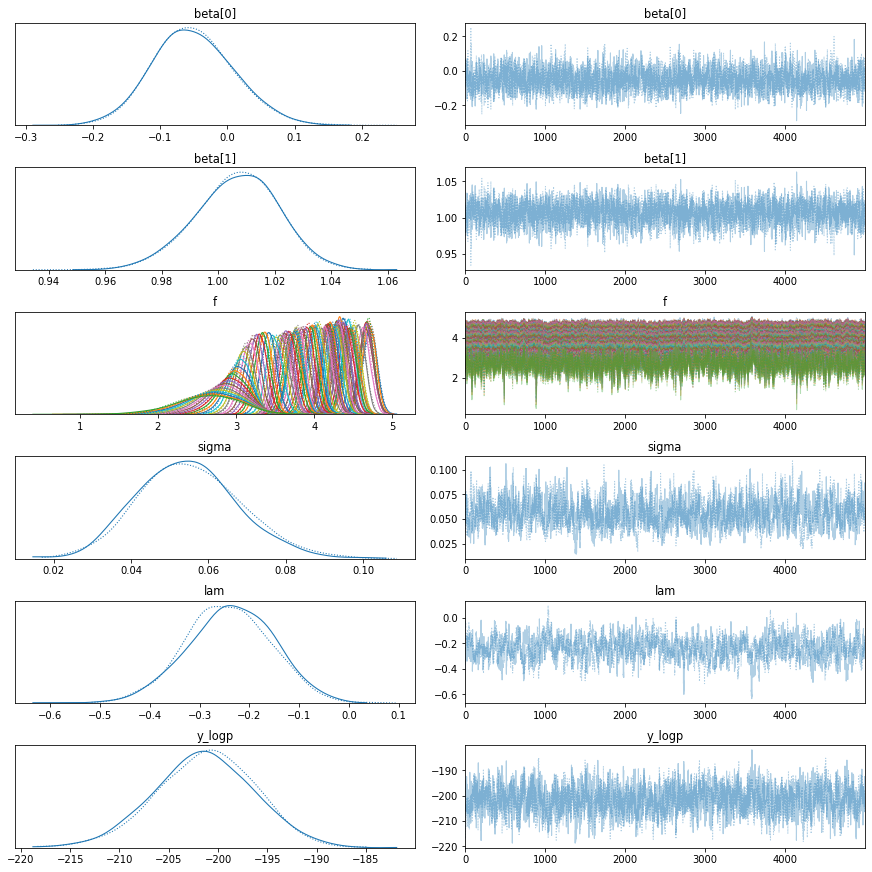

In [8]:
pm.traceplot(trace);

In [9]:
with model:
    y_future = GenPoisson('y_future', theta=tt.exp(f[-F:]), lam=lam, shape=F, testval=1)
    forecasts = pm.sample_posterior_predictive(trace, vars=[y_future], random_seed=42)
samples = forecasts['y_future']

100%|██████████| 10000/10000 [00:11<00:00, 890.13it/s]


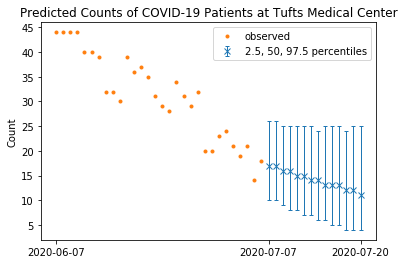

In [10]:
low = np.zeros(F)
high = np.zeros(F)
median = np.zeros(F)

for i in range(F):
    low[i] = np.percentile(samples[:,i], 2.5)
    high[i] = np.percentile(samples[:,i], 97.5)
    median[i] = np.percentile(samples[:,i], 50)

x_future = np.arange(F)
plt.errorbar(x_future, median,
             yerr=[median-low, high-median],
             capsize=2, fmt='x', linewidth=1,
             label='2.5, 50, 97.5 percentiles')
x_past = np.arange(-30,0)
plt.plot(x_past, y[-30:], '.', label='observed')

plt.xticks([-30, 0, F-1],
           [start + timedelta(-30), start, start + timedelta(F-1)])

plt.legend();
plt.title('Predicted Counts of COVID-19 Patients at Tufts Medical Center')
plt.ylabel('Count')
plt.show()

## References

Contributed by Alexandra Hope Lee. This example is adapted from the modeling work described in this paper:

A. H. Lee, P. Lymperopoulos, J. T. Cohen, J. B. Wong, and M. C. Hughes. Forecasting COVID-19 Counts at a Single Hospital: A Hierarchical Bayesian Approach. In ICLR 2021 Workshop on Machine Learning for Preventing and Combating Pandemics, 2021. https://arxiv.org/abs/2104.09327.

Resources on the Generalized Poisson distribution:
- https://www.tandfonline.com/doi/pdf/10.1080/03610929208830766
- https://journals.sagepub.com/doi/pdf/10.1177/1536867X1201200412
- https://towardsdatascience.com/generalized-poisson-regression-for-real-world-datasets-d1ff32607d79
- https://www.tandfonline.com/doi/abs/10.1080/01966324.1997.10737439?journalCode=umms20